# Required import

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import svm

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

from src.utils import load_and_regularize_covariance_matrices, calculate_covariance_means
from pyriemann_qiskit.classification import QuanticSVM, QuanticNCH
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from pyriemann_qiskit.utils.hyper_params_factory import gen_x_feature_map, gen_z_feature_map

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann_qiskit.ensemble import JudgeClassifier
from sklearn.ensemble import RandomForestClassifier

from pyriemann_qiskit.visualization.manifold import plot_manifold
from pyriemann.utils.viz import plot_biscatter, plot_bihist, plot_cov_ellipse
from pyriemann.utils import mean_covariance

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define custom spatial filtering

In [2]:
class PCA_SPD(TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        return self
    
    def transform(self, X, y=None):
        X = np.array(X)
        new_dataset = np.zeros((X.shape[0], self.n_components, self.n_components))
        for i in range(X.shape[0]):
            covariance_to_reduce = X[i]
            eigenvalues, eigenvectors = np.linalg.eigh(covariance_to_reduce) # Calculate eigenvalues and eigenvectors            
            idx = eigenvalues.argsort()[::-1] # Sort eigenvalues in descending order
            eigenvectors = eigenvectors[:,idx][:,:self.n_components] # Sort eigenvectors according to eigenvalues and get the first n_components
            reduced_covariance = eigenvectors.T @ np.diag(eigenvalues) @ eigenvectors            
            new_dataset[i] = reduced_covariance            
        return new_dataset 

# Extract data

In [3]:
c_dataset = load_and_regularize_covariance_matrices(deep_features_type='covs_DN20', group_type='CG')
c_dataset_covs = calculate_covariance_means(c_dataset) #Generalized eigenvalue covariance mean
c_nsubjects = len(c_dataset_covs)
c_nvideos = len(c_dataset_covs[0])
c_covdim = len(c_dataset_covs[0][0])
c_dataset_covs_reshaped = np.array(c_dataset_covs).reshape((c_nsubjects * c_nvideos, c_covdim, c_covdim))

pk_dataset = load_and_regularize_covariance_matrices(deep_features_type='covs_DN20', group_type='PG')
pk_dataset_covs = calculate_covariance_means(pk_dataset)
pk_nsubjects = len(pk_dataset_covs)
pk_nvideos = len(pk_dataset_covs[0])
pk_covdim = len(pk_dataset_covs[0][0])
pk_dataset_covs_reshaped = np.array(pk_dataset_covs).reshape((pk_nsubjects * pk_nvideos, pk_covdim, pk_covdim))
X = np.concatenate([c_dataset_covs_reshaped, pk_dataset_covs_reshaped], axis=0)
y = np.concatenate([np.zeros(c_nsubjects * c_nvideos), np.ones(pk_nsubjects * pk_nvideos)])

Patients:   0%|          | 0/11 [00:00<?, ?it/s]

Patients [Covariance mean]: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


# Visualize data

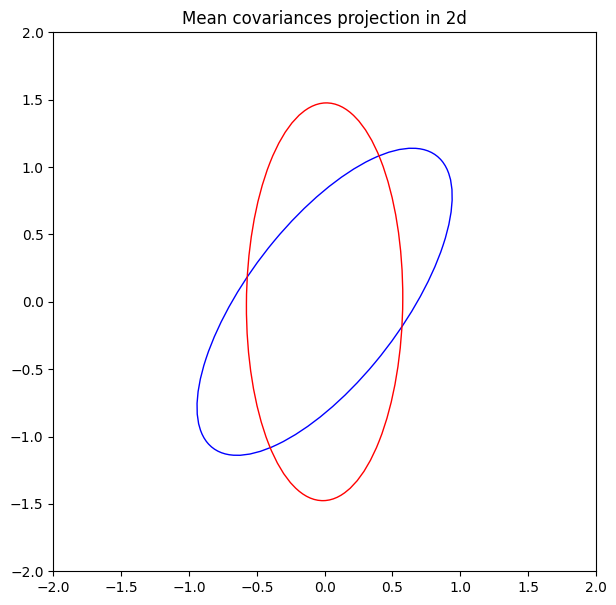

In [65]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title("Mean covariances projection in 2d")
X2x2 = PCA_SPD(n_components=2).transform(X)
c_meancov = mean_covariance(X2x2[:c_nsubjects], metric="logeuclid")
plot_cov_ellipse(ax, c_meancov, edgecolor="blue")
pk_meancov = mean_covariance(X2x2[c_nsubjects:], metric="logeuclid")
plot_cov_ellipse(ax, pk_meancov, edgecolor="red")
min_, max_ = -2, 2
ax.set_xlim(min_, max_)
ax.set_ylim(min_, max_)
plt.show()

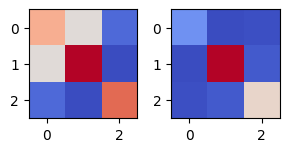

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 1.5, 2 * 1.5))      
X3x3 = PCA_SPD(n_components=3).transform(X)       
c_meancov = mean_covariance(X3x3[:c_nsubjects], metric="logeuclid")
pk_meancov = mean_covariance(X3x3[c_nsubjects:], metric="logeuclid")
axes[0].imshow(c_meancov, cmap='coolwarm')  
axes[1].imshow(pk_meancov, cmap='coolwarm')  

plt.tight_layout()
plt.show()

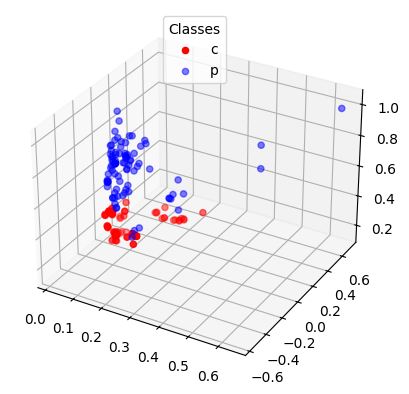

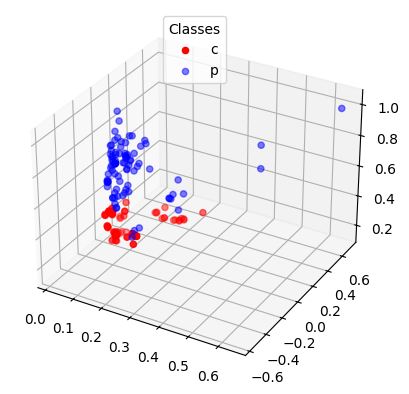

In [70]:
labels = np.array([''] * len(y))
labels[y == 0] = 'c'
labels[y == 1] = 'pk'
plot_manifold(X2x2, labels, False)

# Define pipelines

In [73]:
pipe_ts_svm = make_pipeline(TangentSpace(metric='logeuclid'), svm.SVC())
pipe_ts_qsvm = make_pipeline(TangentSpace(metric='logeuclid'), PCA(n_components=10), QuanticSVM())
pipe_ts_qsvm2 = make_pipeline(
    # Whitening(metric="logeuclid", dim_red={'n_components': 2}),
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    QuanticSVM(gen_feature_map=gen_x_feature_map(), pegasos=False))
pipe_mdm = make_pipeline(
    PCA_SPD(n_components=2),
    MDM(metric='logeuclid'))
pipe_nch = make_pipeline(
    PCA_SPD(n_components=2),
    QuanticNCH(
        n_hulls_per_class=1,
        n_samples_per_hull=3,
        n_jobs=12,
        subsampling="random",
        quantum=False,
    )
)
pipe_classical = make_pipeline(
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    svm.SVC()
)
pipe_lda = make_pipeline(
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    svm.SVC()
)
pipe_ens = make_pipeline(
    PCA_SPD(n_components=2),
    TangentSpace(metric='logeuclid'),
    JudgeClassifier(
        clfs=[LDA(),QuanticSVM(gen_feature_map=gen_x_feature_map(), pegasos=False)],
        judge=RandomForestClassifier(n_estimators=100)
    )
)

[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier


# Evaluate

In [77]:
scores_svm = cross_val_score(pipe_ts_svm, X, y, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=3))
scores_qsvm = cross_val_score(pipe_ts_qsvm2, X, y, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=3))
print(f'scores svm: {scores_svm.mean()}')
print(f'scores qsvm: {scores_qsvm.mean()}')

                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (117, 3)
[QClass]  Feature dimension =  3
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  770170
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (117, 3)
[QClass]  Feature dimension =  3
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  770170
[QClass]  SVM initiating algorithm
[QClass]  Training...


                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Prediction finished.
[QClass]  Initializing Quantum Classifier
[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (118, 3)
[QClass]  Feature dimension =  3
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  770170
[QClass]  SVM initiating algorithm
[QClass]  Training...
[QClass]  Prediction finished.
scores svm: 0.8965517241379309
scores qsvm: 0.9500000000000001


# Corrected t-test

In [90]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [93]:
differences = scores_qsvm - scores_svm
n = differences.shape[0]  # number of test sets
df = n - 1
cv = StratifiedKFold(n_splits=3)
n_train = len(list(cv.split(X, y))[0][0])
n_test = len(list(cv.split(X, y))[0][1])
_, p_value = compute_corrected_ttest(differences, df, n_train, n_test)
print(p_value) # fails to conclude that qsvm has a better performance than svm
# BUT: does not mean it is the same -> we need the bayesian approach or the random testing

0.3367470804728848


# Grid Search

In [ ]:
# Score with gridsearch
# Leave 20 percent out, to avoid biases in the choice of the hyperparameter
# (how well this tuned pipeline is doing with new data?)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)
params = {
    "quanticsvm__C": [0.1, 1, 10],
    "quanticsvm__gamma": ["auto", "scale"],
    "quanticsvm__gen_feature_map": [gen_z_feature_map(), gen_x_feature_map()],
    "tangentspace__metric": ["riemann", "logeuclid"],
    "pca_spd__n_components": [2, 3]
}
gs = GridSearchCV(pipe_ts_qsvm2, params, scoring="balanced_accuracy", cv=StratifiedKFold(n_splits=3))
gs.fit(X_train, y_train)
print(gs.best_params_)
print(f'best score {gs.best_score_}')
score = gs.score(X_test, y_test)
print(f'validation score {score}')

# Evaluate difference in predictions

In [84]:
# We take a small samples and compare the prediction made by classical/quantum pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.9)
y_pred_svc = pipe_ts_svm.fit(X_train, y_train).predict(X_test)
y_pred_qsvc= pipe_ts_qsvm2.fit(X_train, y_train).predict(X_test)

                    Using FidelityStatevectorKernel with AerStatevector.
                    Seed cannot be set with FidelityStatevectorKernel.
                    Increase the number of shots to diminish the noise.


[QClass]  Quantum simulation will be performed
GPU optimization disabled. No device found.
[QClass]  Fitting:  (17, 3)
[QClass]  Feature dimension =  3
[QClass]  Quantum backend =  AerSimulator('aer_simulator_statevector')
[QClass]  seed =  770170
[QClass]  SVM initiating algorithm
[QClass]  Training...
[QClass]  Prediction finished.


/tmp/ipykernel_7522/2375120052.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['False', '', '', '', '', 'True'])
/tmp/ipykernel_7522/2375120052.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([i if i % 2 == 0 else '' for i in range(len(data.index))])


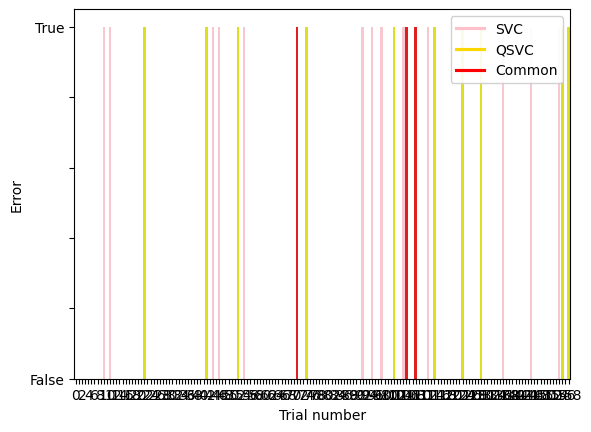

In [85]:
# Display the error made by the two classifier
error_svc = abs(y_test - y_pred_svc)
error_qsvc = abs(y_test - y_pred_qsvc)

error_common = (error_svc == 1) & (error_qsvc == 1)

data = pd.DataFrame({"SVC": error_svc, "QSVC": error_qsvc, "Common": error_common})

sns.barplot(data, x=data.index, y="SVC", color="pink")
sns.barplot(data, x=data.index, y="QSVC", color="yellow")
ax = sns.barplot(data, x=data.index, y="Common", color="red")

# Met en forme la numerotation et le nom des axes
ax.set(xlabel='Trial number', ylabel='Error')
ax.set_yticklabels(['False', '', '', '', '', 'True'])
ax.set_xticklabels([i if i % 2 == 0 else '' for i in range(len(data.index))])

# Legend
plt.legend(title='', loc='upper right', labels=['SVC', 'QSVC', 'Common'], framealpha=0.9)
leg = plt.gca().get_legend()
leg.legend_handles[0].set_color('pink')
leg.legend_handles[1].set_color('#FFD700')
leg.legend_handles[2].set_color('red')

# Separation between classes

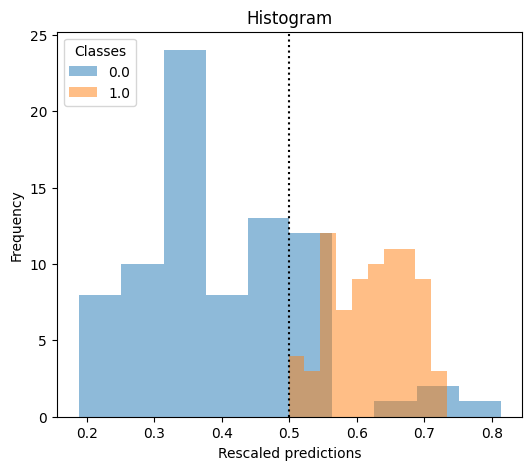

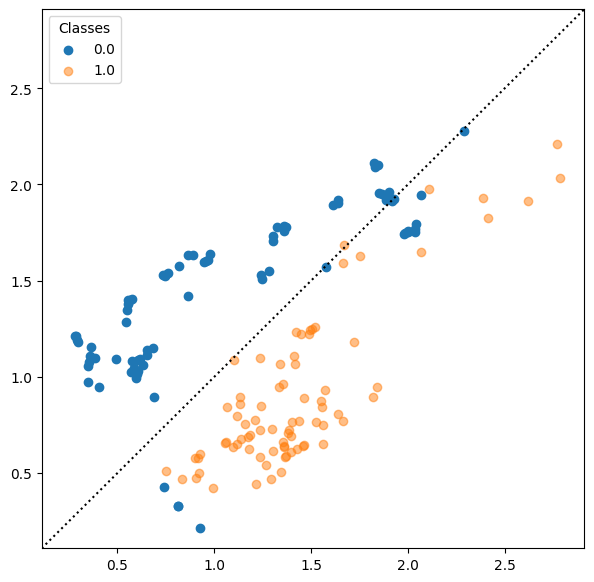

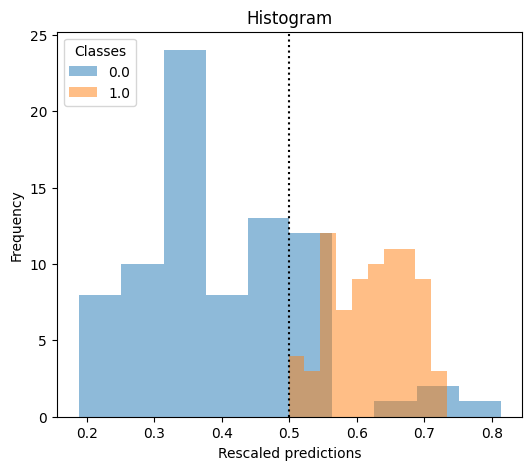

In [89]:
# Use mdm to get the distances between the classes
dists = pipe_mdm.fit(X_train, y_train).transform(X_test)
plot_biscatter(dists, y_test)
plot_bihist(dists, y_test)

[QClass]  Classical computation will be performed
[QClass]  Fitting:  (17, 2, 2)
[QClass]  Feature dimension =  2
[QClass]  Nearest Convex Hull Classifier initiating algorithm
[QClass]  Using ClassicalOptimizer
[QClass]  Training...
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier
[QClass]  Initializing Quantum Classifier


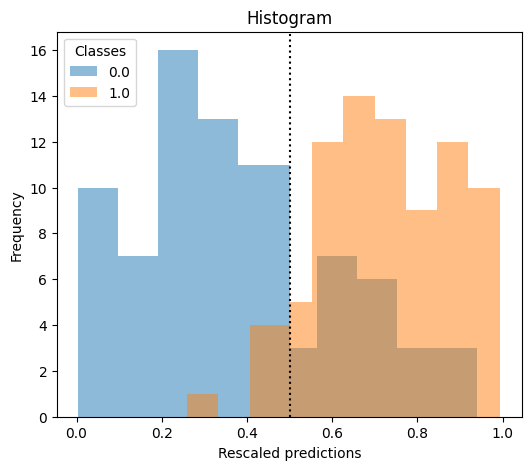

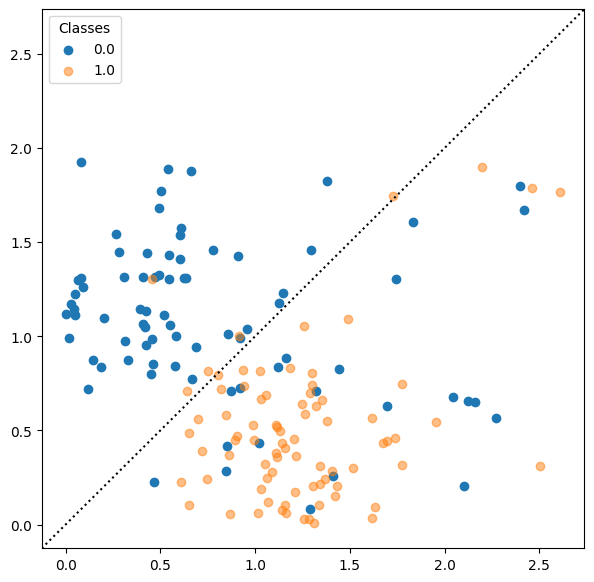

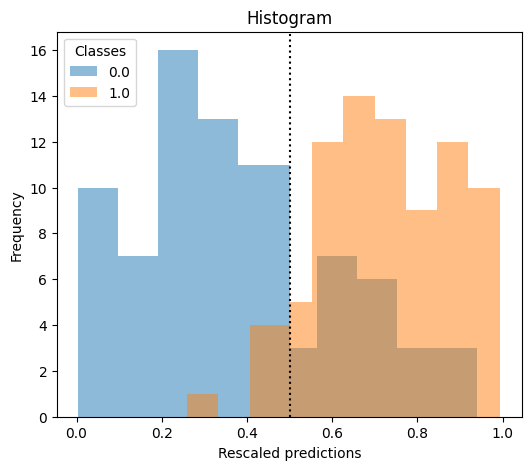

In [88]:
# Use NCH to get the distances between the classes (distance to convex hull)
dists = pipe_nch.fit(X_train, y_train).transform(X_test)
plot_biscatter(dists, y_test)
plot_bihist(dists, y_test)